In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [2]:
def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data

def calc_mm_model(true_model_coefficients, x, args = None):
    """
    Calculates the value of y for case study 1
    
    Parameters
    ----------
    true_model_coefficients: ndarray, The array containing the true values of Theta1 and Theta2
    x: ndarray, The list of xs that will be used to generate y
    args: dict, extra arguments to pass to the function. Default None
    
    Returns
    --------
    y_poly: ndarray, The noiseless values of y given theta_true and x
    """
    t1, t2, t3 = true_model_coefficients
    y_poly =  t1*(1-t2*np.exp(-t3*x))
    
    return y_poly

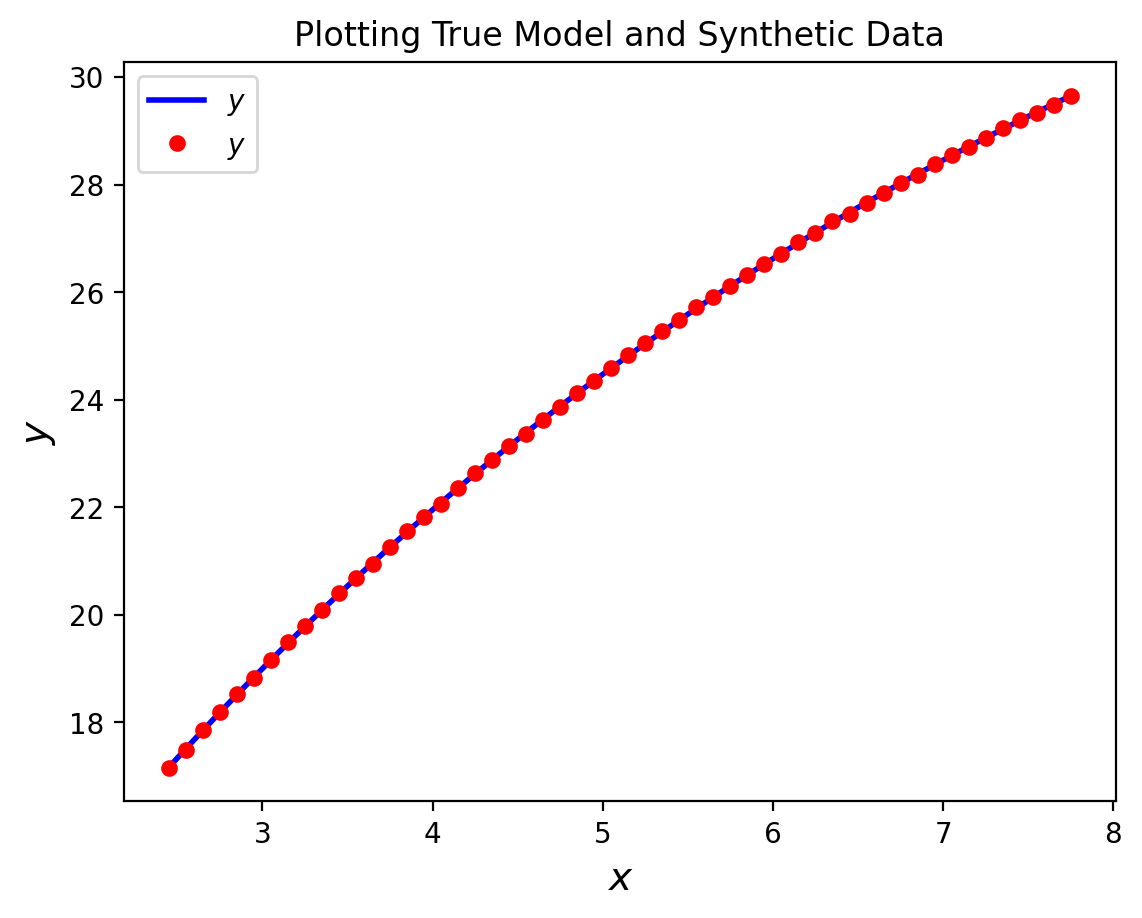

CPU times: total: 328 ms
Wall time: 346 ms


In [3]:
%%time

param_name_str = "t1t2t3"
indeces_to_consider = [0,1,2]

bounds_x = np.array([[2.45],[7.75]])
bounds_theta_l = [35, 0, 0]
bounds_theta_u = [ 40, 1, 1]
theta_ref = np.array([39.09, 0.828, 0.159]) 
theta_names = ['theta_1', 'theta_2', 'theta_3']
theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
Xexp = np.arange(2.45, 7.76, 0.1).reshape(-1,1)
num_points = len(Xexp)
# Yexp_org = np.array([17.3,17.6,17.9,18.3,18.5,18.9,19.0,19.3,19.8,19.9,20.2,20.5,20.6, 21.1,21.5,21.9,22.0,22.3,22.6,22.8,23.0,23.2,23.4,23.7,24.0
# ,24.2,24.5,25.0,25.4, 25.5,25.9, 25.9,26.3,26.2,26.5,26.5,26.6,27.0,27.0,27.0,27.0,27.3,27.8,28.1,28.1,28.1,28.4,28.6,29.0, 29.2,29.3,29.4,29.4,29.4])
Xexp = grid_sampling(num_points, bounds_x)
Yexp_org = np.array([ calc_mm_model(theta_ref, Xexp[i])  for i in range(len(Xexp)) ]).flatten()
noise = np.random.normal(size=len(Yexp_org), loc = 0, scale = 0.01)
Yexp = Yexp_org + noise

# Evaluate model based on the assumed experimental values
X = np.linspace(np.min(Xexp),np.max(Xexp),100).reshape(-1,1)
Y = calc_mm_model(theta_ref, X.reshape(-1,1))

# Compare the experiments to the true model
plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.plot(Xexp,Yexp,'r.',markersize=10,label=r"$y$")
plt.title("Plotting True Model and Synthetic Data")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()

In [4]:
##New Cell

## define function that includes nonlinear model
def model(theta_guess, theta_ref, x, indeces_to_consider):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Define an array to store y values in
    y_data = []
    #Loop over all theta values
    for i in range(len(x)):
        #Create model coefficient from true space substituting in the values of param_space at the correct indeces
        model_coefficients = theta_ref.copy()
        #Replace coefficients a specified indeces with their theta_val counterparts
        model_coefficients[indeces_to_consider] = theta_guess              
        #Create y data coefficients
        y = calc_mm_model(model_coefficients, x[i])
        y_data.append(y)
        # print(model_coefficients, x[i], y)

    #Convert list to array and flatten array
    y_model = np.array(y_data).flatten()
    
    return y_model

print(model(theta_true, theta_true, Xexp, indeces_to_consider))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, theta_ref, x, indeces_to_consider, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    error = y - model(theta_guess, theta_ref, x, indeces_to_consider) #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

print(regression_func(theta_true, theta_true, Xexp, indeces_to_consider, Yexp))

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(theta_guesses, theta_ref, indeces_to_consider, Xexp, Yexp):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Initialize sse grid
    sse = np.zeros(len(theta_guesses))
    
    #For each guess
    for i in range(len(theta_guesses)):
        #Evaluate the model
        y_sim = model(theta_guesses[i], theta_ref, Xexp, indeces_to_consider)
        #Calculate SSE
        sse[i] = np.sum((y_sim - Yexp)**2)
     
    sse = sse.reshape(int(np.sqrt(len(theta_guesses))), -1).T
    
    return sse

print(sse_func([theta_true], theta_true, indeces_to_consider, Xexp, Yexp))

[17.16616162 17.511994   17.85237113 18.18737905 18.51710248 18.84162476
 19.16102794 19.47539278 19.78479873 20.08932404 20.38904569 20.68403945
 20.9743799  21.26014044 21.54139332 21.81820965 22.0906594  22.35881146
 22.62273361 22.88249259 23.13815406 23.38978267 23.63744201 23.88119471
 24.1211024  24.35722572 24.58962436 24.81835709 25.04348173 25.26505519
 25.4831335  25.69777178 25.9090243  26.11694447 26.32158485 26.52299718
 26.72123238 26.91634056 27.10837106 27.29737242 27.48339242 27.66647809
 27.84667572 28.02403087 28.19858837 28.37039235 28.53948625 28.70591282
 28.86971414 29.03093161 29.18960599 29.3457774  29.49948533 29.65076862]
[-0.01029241 -0.02266202  0.01151616 -0.0021472   0.00634431 -0.00610726
  0.0062434   0.01601024  0.00188639  0.0055156   0.01849652  0.00646335
 -0.02710806 -0.00030115  0.00900581  0.00879402 -0.02123367  0.00848688
  0.02159588  0.00035273  0.0044964  -0.02106531 -0.00693872 -0.00809074
 -0.00414935 -0.00395587 -0.00135189  0.00684378  

In [5]:
#Set seed and repeats
# seed = 4
# np.random.seed(seed)

## specify bounds
lower = np.array([bounds_theta_l[i] for i in indeces_to_consider] )
upper = np.array([bounds_theta_u[i] for i in indeces_to_consider] )
bounds = (lower, upper)
print(bounds)

## specify initial guesses
theta_guess = np.random.uniform(low=lower, high=upper, size=len(lower) )
print(theta_guess)

Solution = optimize.least_squares(regression_func, theta_guess, bounds=bounds, method='trf',
                                    args=(theta_true, Xexp.reshape(-1,1), indeces_to_consider, Yexp),verbose=0)

nlr_theta = Solution.x

print("Best Theta = ", nlr_theta)
print("theta_ref", theta_true)
Y_nlr_exp = model(nlr_theta, theta_true, Xexp, indeces_to_consider)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))

(array([35,  0,  0]), array([40,  1,  1]))
[36.38698557  0.17888919  0.92239657]
Best Theta =  [39.02160764  0.82848312  0.15973976]
theta_ref [39.09   0.828  0.159]
SSE =  0.0076613511547033684


In [6]:
#Create heat map data
#Create list of heat map theta data
heat_map_data_dict = {}

#Create a linspace for the number of dimensions and define number of points
dim_theta = len(theta_true_names)
dim_list = np.linspace(0, dim_theta-1, dim_theta)

#Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
n_points = 20

#Meshgrid set always defined by n_points**2
theta_set = np.tile(np.array(theta_true), (n_points**2, 1))

#Set x_vals
norm_x_vals = Xexp.reshape(-1,1)

#Loop over all possible theta combinations of 2
for i in range(len(mesh_combos)):
    #Create a copy of the true values to change the mehsgrid valus on
    theta_set_copy = np.copy(theta_set)
    #Set the indeces of theta_set for evaluation as each row of mesh_combos
    idcs = mesh_combos[i]
    #define name of parameter set as tuple ("param_1,param_2")
    data_set_name = (theta_true_names[idcs[0]], theta_true_names[idcs[1]])

    #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
    #Assume that theta1 and theta2 have equal number of points on the meshgrid
    theta1 = np.linspace(lower[idcs[0]], upper[idcs[0]], n_points)
    theta2 = np.linspace(lower[idcs[1]], upper[idcs[1]], n_points)
    theta12_mesh = np.array(np.meshgrid(theta1, theta2))
    theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

    #Set initial values for evaluation (true values) to meshgrid values
    theta_set_copy[:,idcs] = theta12_vals
    
    #Append data set to dictionary with name
    heat_map_data_dict[data_set_name] = theta_set_copy
    
hm_data_keys = list(heat_map_data_dict.keys())
print(hm_data_keys)
print(heat_map_data_dict[hm_data_keys[0]].shape)

[('theta_1', 'theta_2'), ('theta_1', 'theta_3'), ('theta_2', 'theta_3')]
(400, 3)


c:\Users\mcarlozo\Documents\Repos\Toy_Problem\bo_methods_lib\bo_methods_lib\GPBO_Classes_plotters.py:1546: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


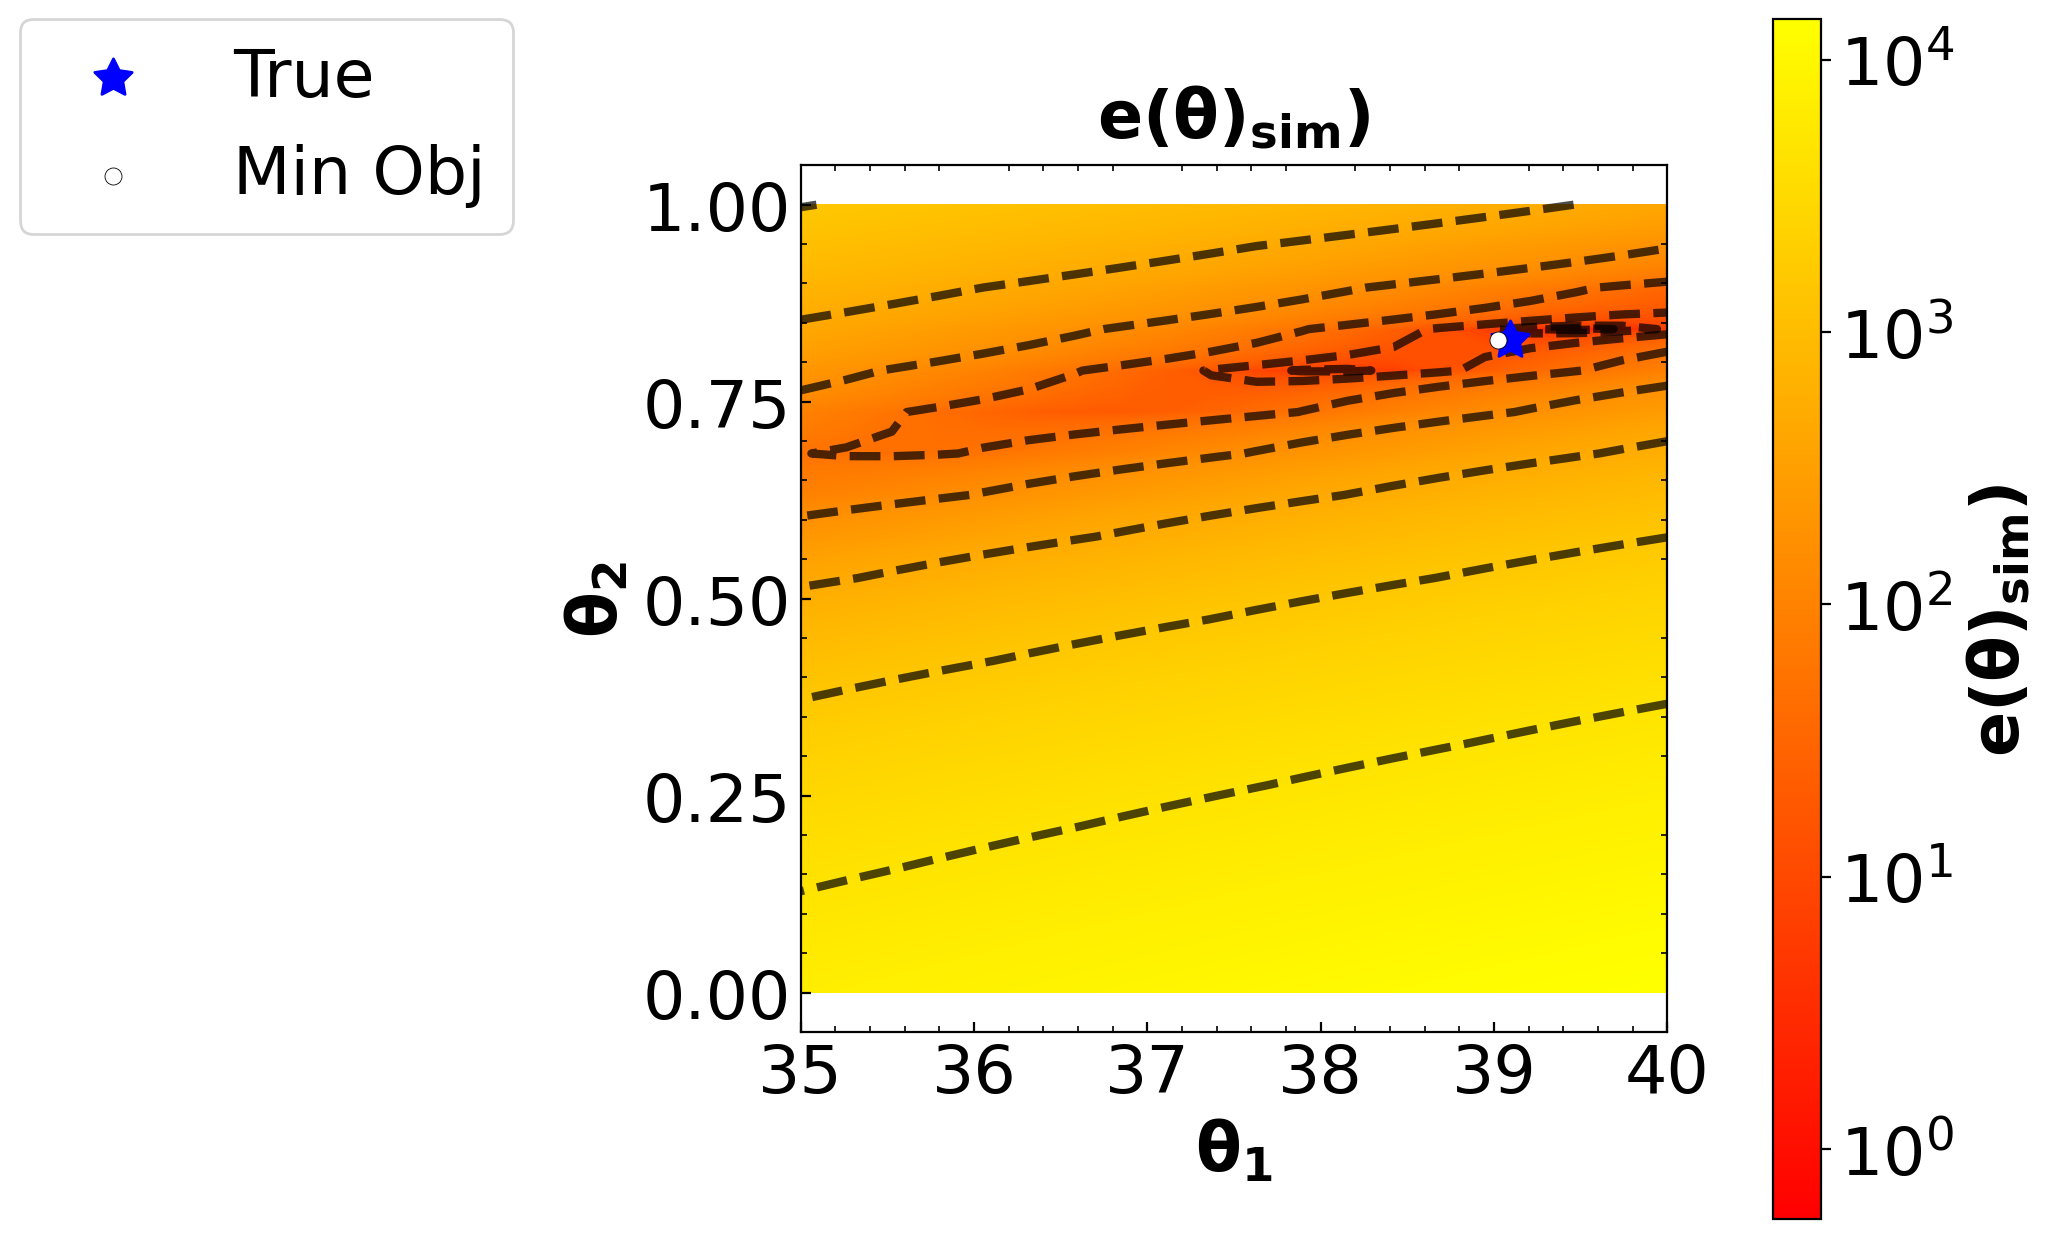

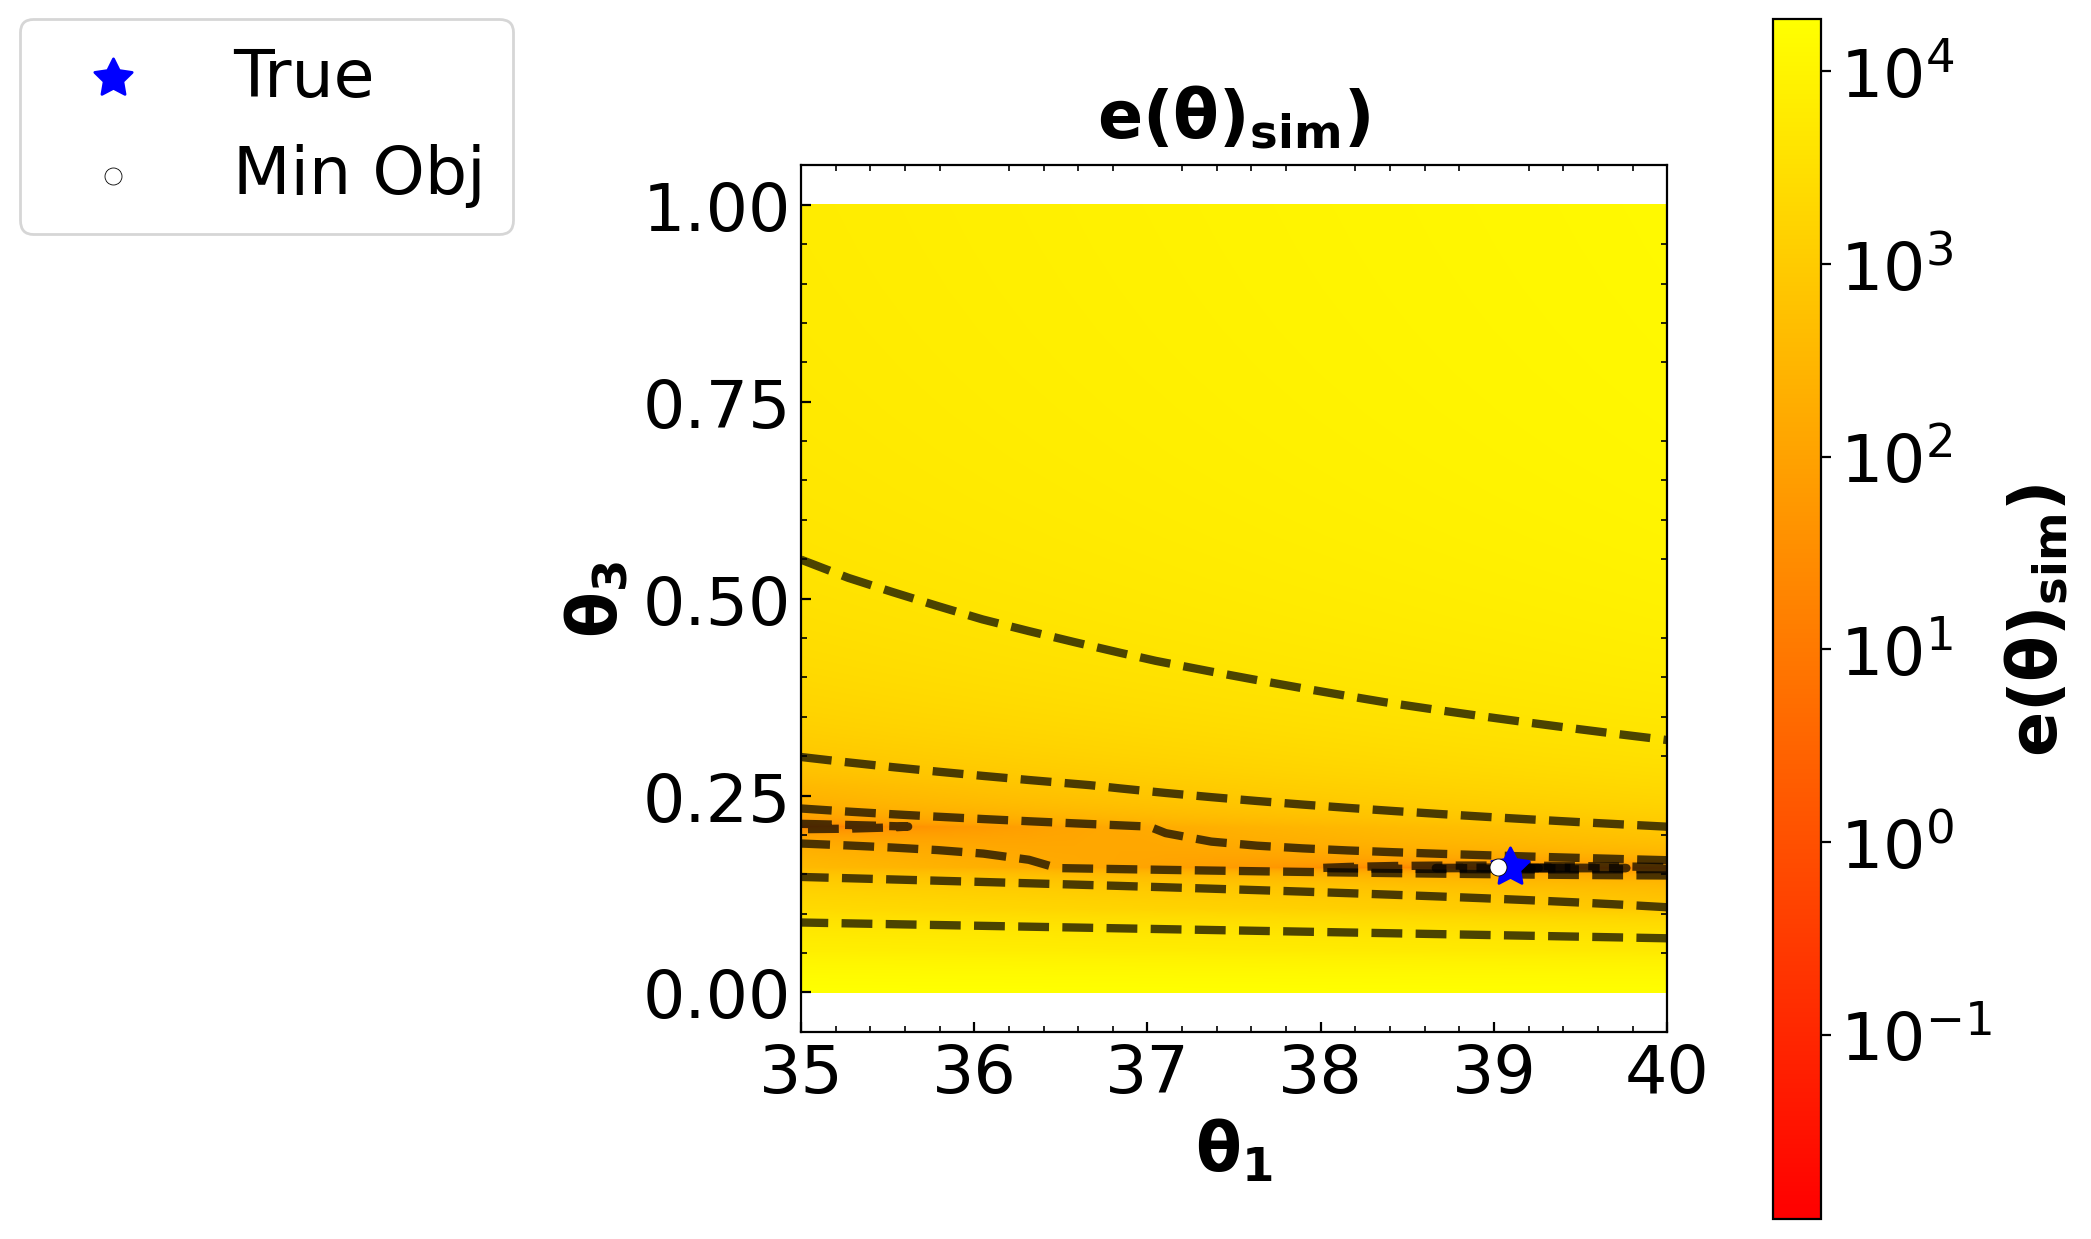

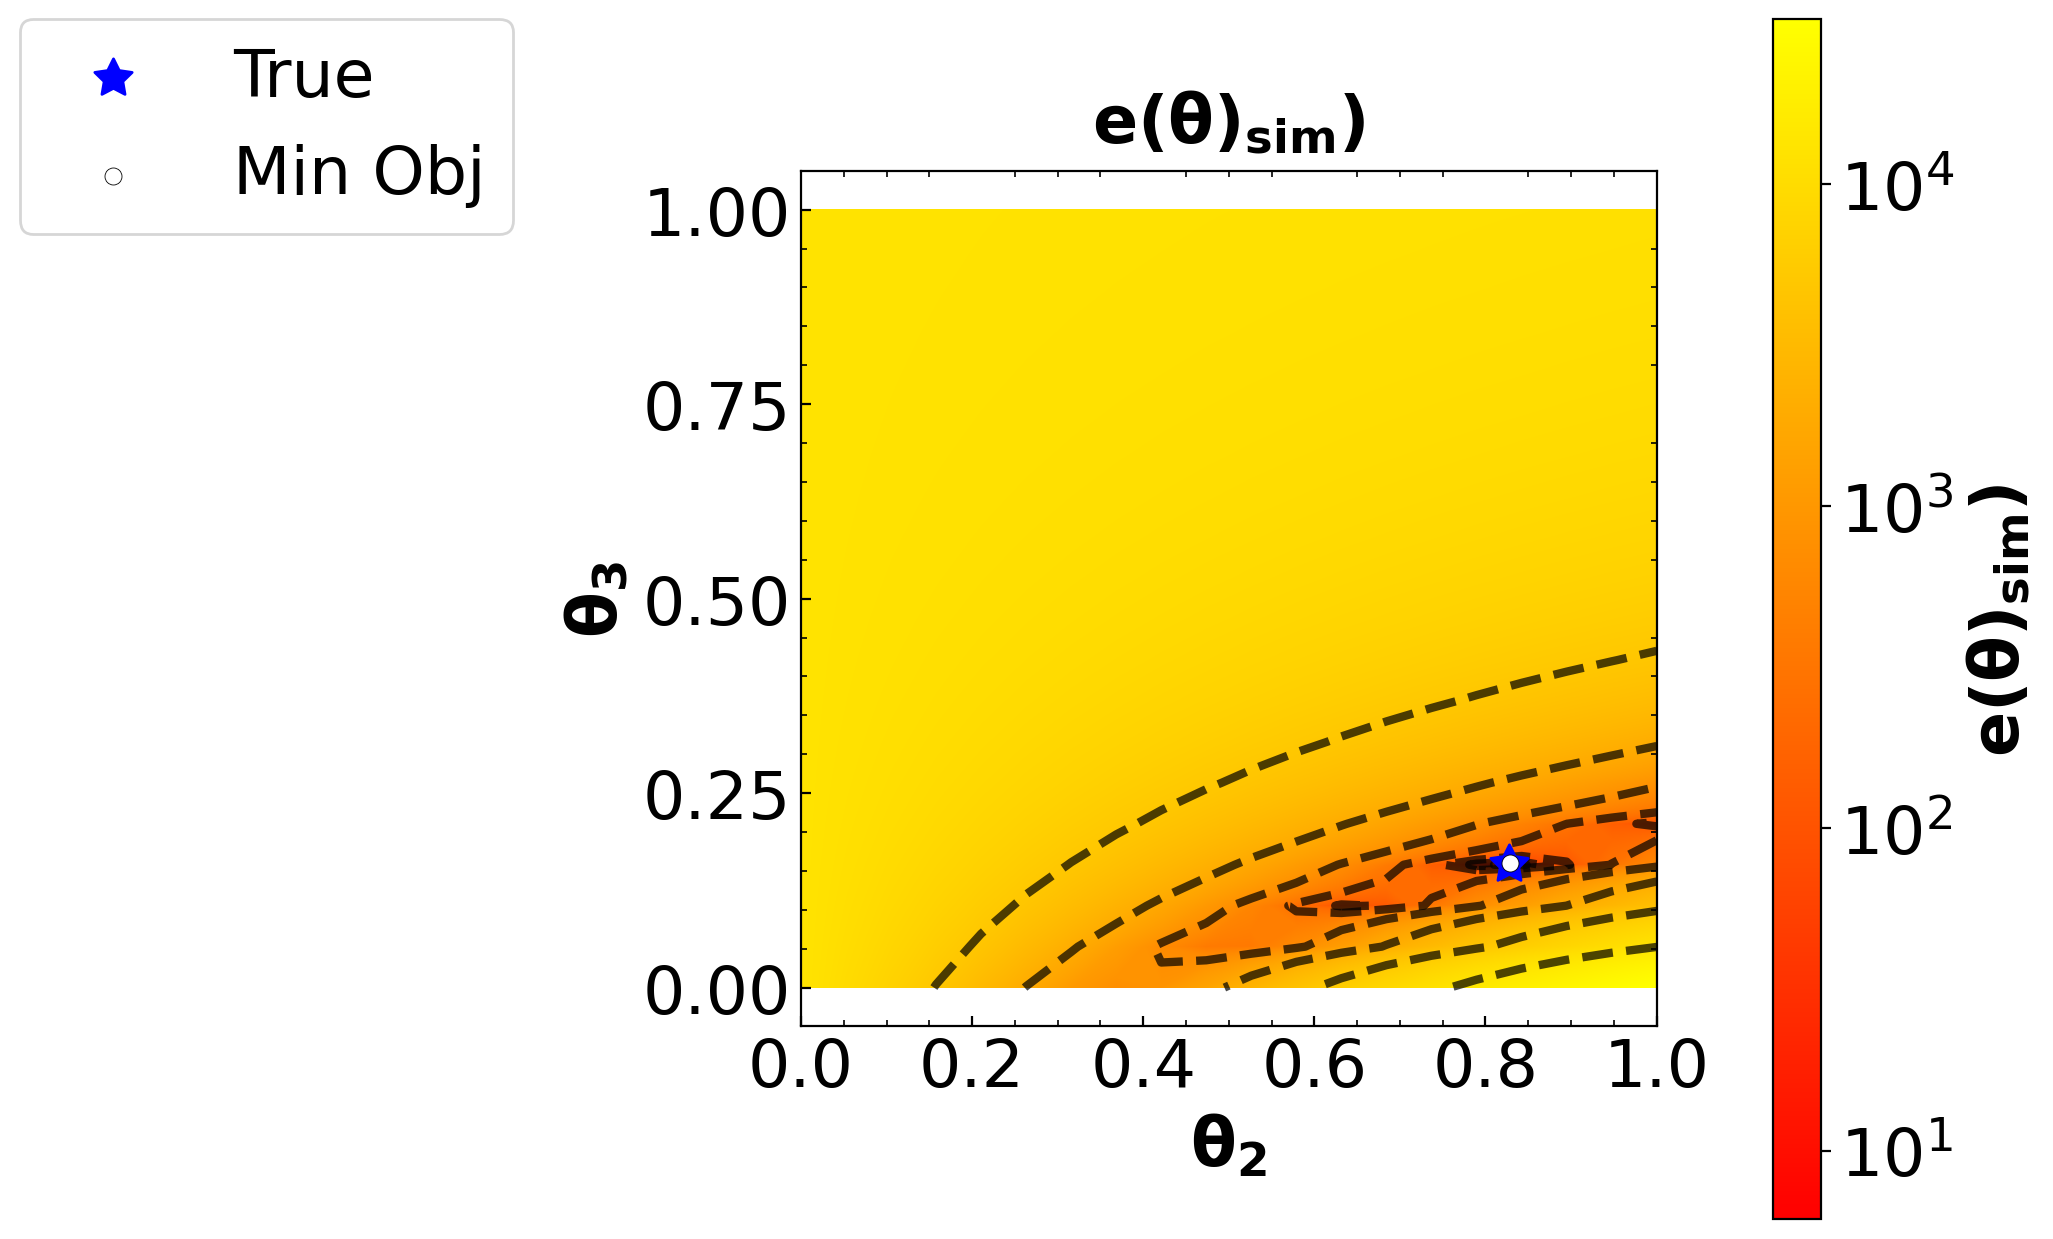

In [7]:
#New Cell
log_data = False
# save_figure = True
save_figure = False


#Get Number of pairs
combos = list(combinations(dim_list, 2))
pairs = len((list(combinations(dim_list, 2))))

#For each pair
for pair in range(pairs):
    #Make a meshgrid for each parameter
    idcs_to_plot = [int(combos[pair][i]) for i in range(len(combos[pair]))]
    theta_data = heat_map_data_dict[hm_data_keys[pair]].reshape(n_points, n_points, -1).T
    theta_mesh = np.take(theta_data, list(combos[pair]), axis=0)
    
    sse_sim = sse_func(heat_map_data_dict[hm_data_keys[pair]], theta_ref, indeces_to_consider, Xexp.reshape(-1,1), Yexp)
    param_names = theta_true_names[idcs_to_plot]
    
    title = "Heat Map Pair " + "-".join(map(str, param_names))
    title = None

    z = np.array([sse_sim])
    if log_data == True:
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")"]
        z = np.log(z)
    else:
        z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")"]
    
#     z_save_names = ["sse_sim", "sse_nlr"]
#     path_end = '-'.join(z_save_names) 
    levels = [100]

    plot_dict = make_plot_dict(log_data, None, None, None, levels, save_path=None)
    plot_nlr_heat_maps(theta_mesh, z, theta_true, nlr_theta, z_titles, param_names, idcs_to_plot, plot_dict)

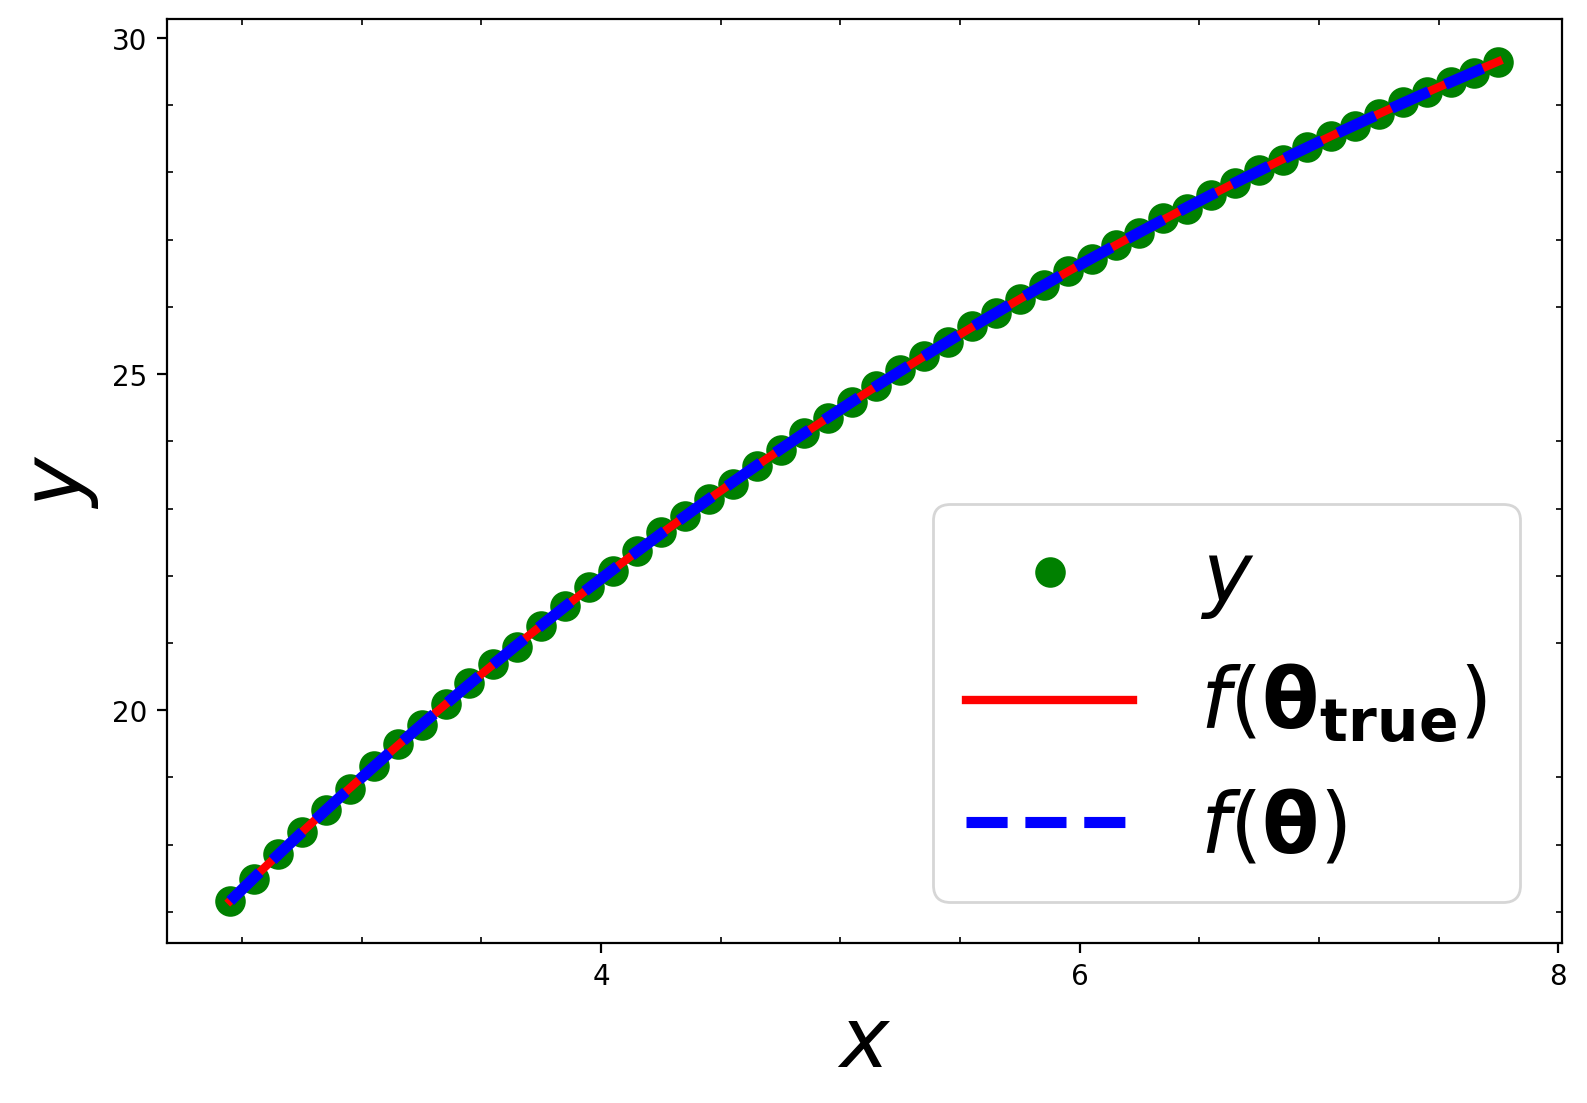

SSE =  0.0076613511547033684


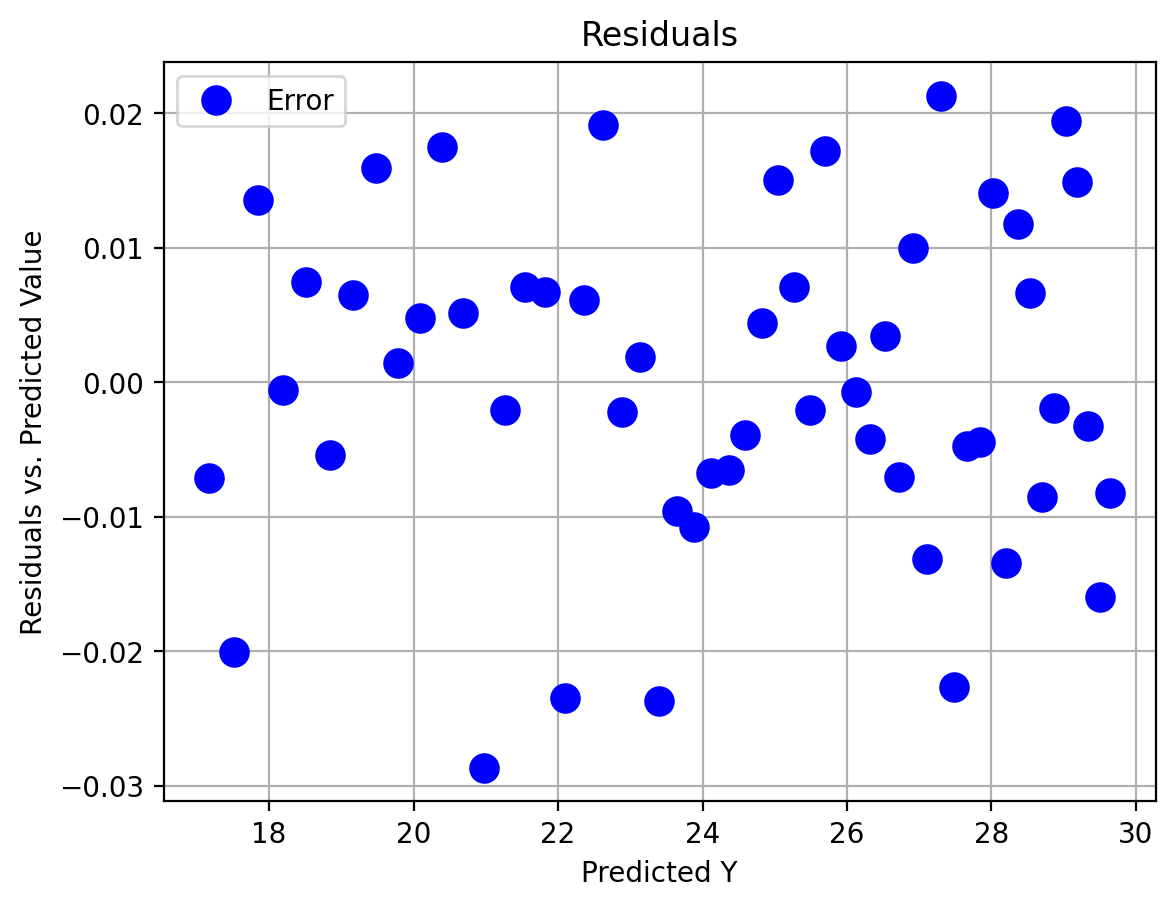

In [8]:
# create plot and compare predictions and experiments
X_pred = np.linspace(bounds_x[0], bounds_x[1]).reshape(-1,1)
Y_pred = model(nlr_theta, theta_true, X_pred, indeces_to_consider).flatten()
plt.figure(figsize = (9,6))
plt.plot(Xexp,Yexp,'.g',markersize=20,label=r'$y$')
plt.plot(X,Y,'r-',linewidth=3,label=r'$f(\mathbf{\theta_{true}})$')
plt.plot(X_pred,Y_pred,'--b',linewidth=4,label=r'$f(\mathbf{\theta})$')
# plt.title("Predictions with $\\theta = [0.994,-1.00]$ vs Synthetic Data")
# plt.title("Predictions with $\\theta = [0.802,-0.757]$ vs Synthetic Data")
plt.legend(loc = "lower right", fontsize=30) #(bbox_to_anchor=(1.04, 1), borderaxespad=0
plt.xlabel(r'$x$',fontsize=30,fontweight='bold')
plt.ylabel(r'$y$',fontsize=30,fontweight='bold')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
# plt.grid(True)

# plt.savefig("Figures/sim_true_comp_poster.png", dpi=300, bbox_inches='tight')
plt.show()


##New Cell

#Plot error
print("SSE = ", np.sum(error**2))
plt.plot(Y_nlr_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
print("Covariance matrix:\n",Sigma_theta2)
print("Det(Covar) = ", np.linalg.det(Sigma_theta2))

Jacobian =

[[ -0.4398335   26.38387728 -53.55356288]
 [ -0.44871049  25.96577048 -54.85611606]
 [ -0.45744682  25.5542891  -56.10393691]
 [ -0.46604469  25.14932871 -57.29843354]
 [ -0.47450632  24.75078559 -58.44098186]
 [ -0.48283386  24.35855818 -59.53292894]
 [ -0.49102942  23.97254634 -60.57559156]
 [ -0.49909512  23.59265161 -61.57025743]
 [ -0.50703299  23.21877742 -62.51818562]
 [ -0.51484507  22.85082769 -63.42060804]
 [ -0.52253335  22.48870945 -64.27872849]
 [ -0.5300998   22.13232923 -65.09372544]
 [ -0.53754634  21.7815969  -65.86674905]
 [ -0.54487488  21.43642187 -66.59892559]
 [ -0.55208728  21.0967176  -67.29135537]
 [ -0.55918538  20.76239634 -67.9451139 ]
 [ -0.566171    20.43337345 -68.56125331]
 [ -0.57304592  20.1095643  -69.14080191]
 [ -0.57981189  19.79088688 -69.68476439]
 [ -0.58647064  19.47725916 -70.19412327]
 [ -0.59302387  19.16860151 -70.66983843]
 [ -0.59947324  18.8648355  -71.11284828]
 [ -0.60582042  18.56588316 -71.52407002]
 [ -0.61206701  18.271